# BioE C142 Final Ugrad Project - Qile Yang

> Instructions: Final results. Train your model with all data and compare your results to what’s reported in the paper. Finish off Jupyter notebooks and organize results.

In [1]:
# notebook and python env setup
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchani
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/qile/miniconda3/lib/python3.12/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/qile/miniconda3/lib/python3.12/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


cuda


## Data Loading and Processing
___

Here I start off by loading and setting up the ANI dataset into `train_data`, `val_data`, and `test_data`.

In [ ]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("data/ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [3]:
print(len(train_data))

691918


In [4]:
print(len(val_data))

86489


## Training Setup
___
Here I setup the training loop and the AEV computer for this specific dataset of small molecules comprised of H, C, N, and O.

In [6]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=l2
        )
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(self.batch_size).cache()
        train_data_len = len(train_data)
        
        # definition of loss function
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                true_energies = train_data_batch["energies"].to(device).float()
                
                # compute loss
                batch_loss = loss_func(
                    true_energies,
                    self.model((
                        train_data_batch['species'].to(device),
                        train_data_batch['coordinates'].to(device)
                    ))[1]
                )
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = len(train_data_batch) / train_data_len
                train_epoch_loss += batch_loss.item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            epochs = np.arange(self.epoch)
            ax.plot(epochs, train_loss_list, label='Train')
            ax.plot(epochs, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        data_len = len(data)
        
        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                true_energies = batch_data["energies"].to(device).float()
                _, pred_energies = self.model((
                    batch_data['species'].to(device),
                    batch_data['coordinates'].to(device)
                ))

                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)

                batch_importance = len(batch_data) / data_len
                total_loss += batch_loss.item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            hartree2kcalmol = (true_energies_all - pred_energies_all) * 627.5094738898777
            mae = np.mean(np.abs(hartree2kcalmol))
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()

        return total_loss

In [5]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


## Model Construction
___
Here I construct the main model I have refined over the course of the project, which uses the AEV computations and feeds it to the same four neural networks for each atom type using an ANN with the architecture 328 (aev dim) - 128 (hidden dim) - CELU - 1 (output energy).

For my final report, I am also interested to evaluate whether using CELU helped at all with gradient flow and convergence, I will also be training a model with ReLU activations instead of CELU activations.

In [7]:
def create_model(model_class: nn.Module) -> nn.Module:
    """Create a model for the ANI small molecule dataset
    by using the same model for all atoms.

    Args:
        model_class (nn.Module): The pytorch model class for a single molecule

    Returns:
        nn.Module: A pytorch model for the whole dataset with aev computation preprocessing
    """
    net_H = model_class()
    net_C = model_class()
    net_N = model_class()
    net_O = model_class()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    return nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)

In [9]:
class FeedForwardCeLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 128),
            nn.CELU(alpha=0.1),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

ff_celu_model = create_model(FeedForwardCeLU).to(device)
ff_celu_model

Sequential(
  (0): AEVComputer()
  (1): ANIModel(
    (0): FeedForwardCeLU(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (1): FeedForwardCeLU(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (2): FeedForwardCeLU(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (3): FeedForwardCeLU(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

## Model Training
___

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 100/100 [14:08<00:00,  8.48s/it]


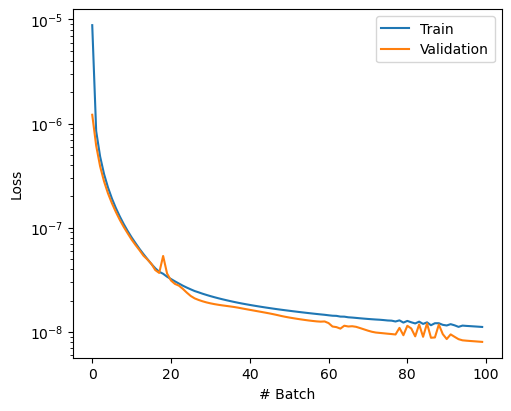

In [10]:
ff_celu_trainer = ANITrainer(
    model=ff_celu_model,
    batch_size=2048,
    learning_rate=1e-4,
    epoch=100,
    l2=0.0
)

ff_celu_train_loss, ff_celu_val_loss = ff_celu_trainer.train(
    train_data,
    val_data,
    early_stop=False,
    draw_curve=True
)

In [12]:
# save the model
torch.save(
    ff_celu_model.state_dict(),
    "models/ff_celu_model.pth"
)

In [ ]:
# get the saved model size in bytes
!du -h models/ff_celu_model.pth

784K	models/ff_celu_model.pth


## Evaluation
___